# Pneumonia Detection Model

&emsp;University of California, San Diego, provided a dataset containing `5856` chest X-ray images from children with labels stating if the images are related to pneumonia patients or people without it. This project builds a deep learning model using the images to determine whether an X-ray shows signs of pneumonia.

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import initializers
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers, losses
from tensorflow.keras import applications

random.seed(4)

## Table of Contents
1. [Import Data](#data)
2. [Data Exploration](#explore)
3. [Sequential Model](#sequential)
4. [Transfer Learning](#transfer)
5. [Model Evaluate](#evaluate)

## <a id='data'>Import Data</a>

In [23]:
import tarfile

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

# Use it like this:
extract_tar_gz('xray_dataset.tar.gz', '')

--2025-02-23 13:55:31--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.141.225, 52.216.215.121, 3.5.29.242, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.141.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz.1’

xray_dataset.tar.gz 100%[===================>]   1.14G  14.0MB/s    in 87s     

2025-02-23 13:56:59 (13.4 MB/s) - ‘xray_dataset.tar.gz.1’ saved [1223407715/1223407715]



In [24]:
train_set = tf.keras.utils.image_dataset_from_directory(
        directory='chest_xray/train/',
        labels='inferred',
        label_mode='categorical',
        batch_size=256,
        image_size=(256,256),
        validation_split=0.25,
        subset="training",
        seed=4)

validation_set = tf.keras.utils.image_dataset_from_directory(
        directory='chest_xray/train/',
        labels='inferred',
        label_mode='categorical',
        batch_size=256,
        image_size=(256,256),
        validation_split=0.25,
        subset="validation",
        seed=4)

test_set = tf.keras.utils.image_dataset_from_directory(
        directory='chest_xray/test/',
        labels='inferred',
        label_mode='categorical',
        batch_size=256,
        image_size=(256,256)
        )

normalization_layer = layers.Rescaling(scale=1/255)

train_set_normalized = train_set.map(lambda image, label: (normalization_layer(image), label))
validation_set_normalized = validation_set.map(lambda image, label: (normalization_layer(image), label))
test_set_normalized = test_set.map(lambda image, label: (normalization_layer(image), label))

Found 5232 files belonging to 2 classes.
Using 3924 files for training.
Found 5232 files belonging to 2 classes.
Using 1308 files for validation.
Found 624 files belonging to 2 classes.


In [25]:
for label in train_set.class_names:
    print(label)

NORMAL
PNEUMONIA


## <a id='explore'>Data Exploration</a>

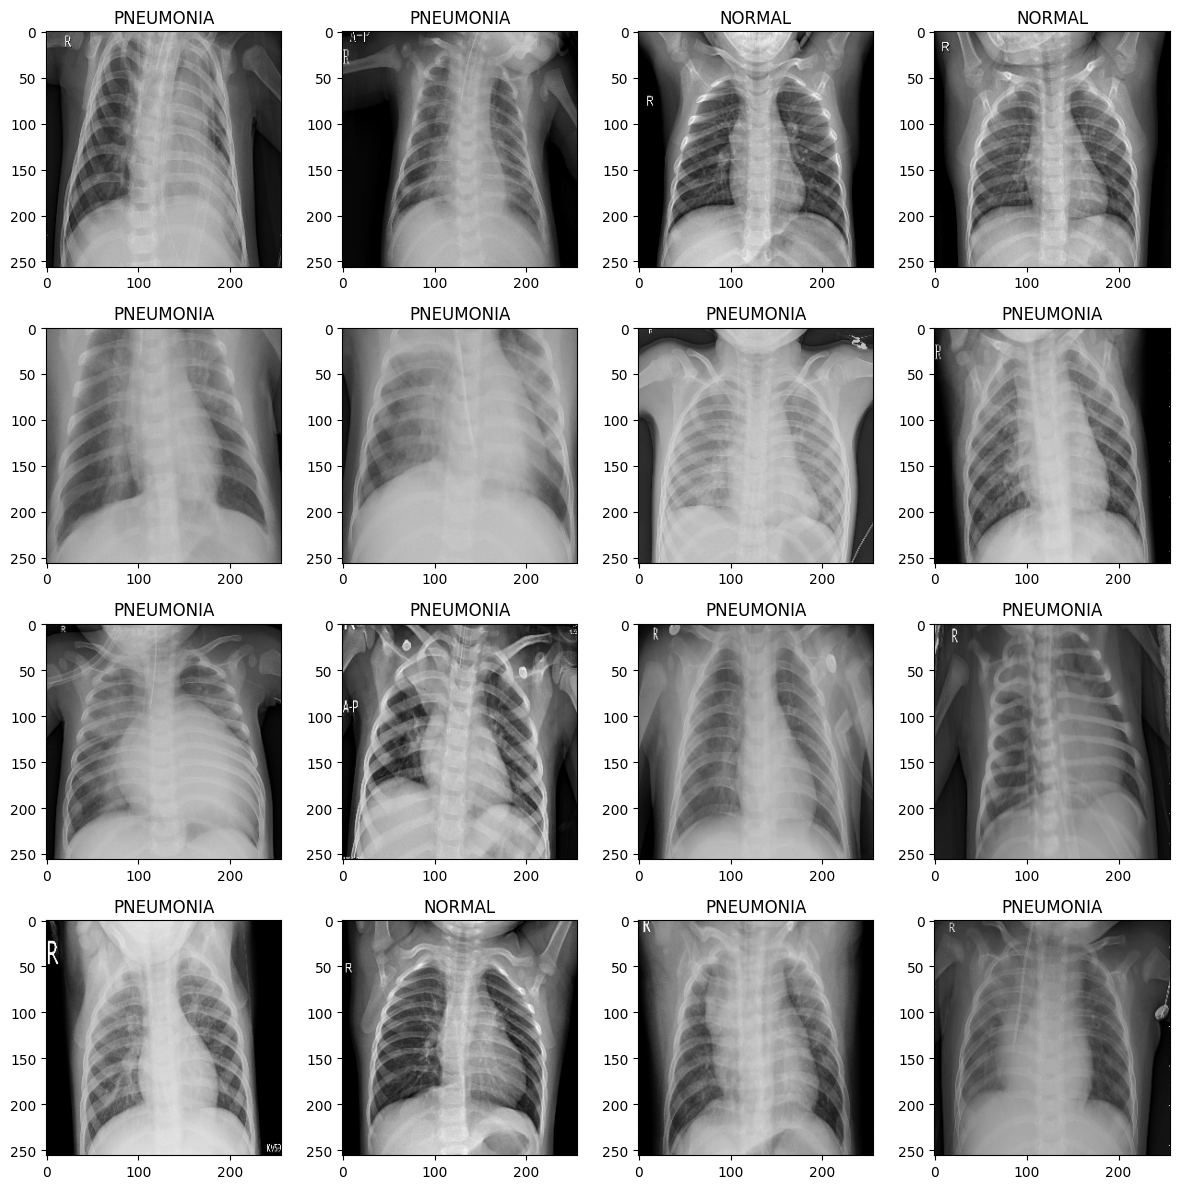

In [26]:
for images, labels in train_set_normalized.take(1):
    images = images
    labels = labels

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title(train_set.class_names[int([idx for idx in range(len(labels[i])) if labels[i][idx]==1][0])])
plt.tight_layout()
plt.show()

* A complex model may not be needed as the images apparently are generally standardised regarding of the position and colour of the children's chests.
* If data augmentations are required, flipping horizontally may yield acceptable results. However, it is not recommended as most of the images above show that the position of the hearts is more to the left side of the children. By flipping horizontally, the heart will be more to the right instead which is not common in practice. Therefore, training on those augmented images may not be helpful.
* As a result, rotation may be a better option in case of needing a data augmentation.

## <a id='sequential'>Sequential Model</a>

In [39]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters=3, kernel_size=3, strides=2, input_shape=(256,256,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(8))
cnn_model.add(layers.Dense(2))
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 127, 127, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 63, 63, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 11907)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │          95,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,366 (372.52 KB)

 Trainable params: 95,366 (372.52 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
opt = optimizers.Adam(learning_rate=.001)
loss = losses.CategoricalCrossentropy(from_logits=True)

cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
cnn_model.fit(train_set_normalized, validation_data=validation_set_normalized, epochs=5)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5632 - loss: 2.4274 - val_accuracy: 0.7638 - val_loss: 0.4455
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6787 - loss: 0.5897 - val_accuracy: 0.7645 - val_loss: 0.5042
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8447 - loss: 0.3866 - val_accuracy: 0.9136 - val_loss: 0.2679
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9237 - loss: 0.2359 - val_accuracy: 0.9243 - val_loss: 0.1964
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9342 - loss: 0.1786 - val_accuracy: 0.9381 - val_loss: 0.1739


* Surprisingly, the simple CNN model performs well without signs of overfitting.
* Nevertheless, a more complex model will be built to aim for `99% accuracy` since *pneumonia* is a serious medical condition with a concerning mortality rate.

## Data Augmentation with Weight Initialisation

In [29]:
weight_initializer = initializers.RandomNormal(mean=0, stddev=.01, seed=4)

cnn_model2 = models.Sequential()
cnn_model2.add(layers.Input(shape=(256,256,3)))
cnn_model2.add(layers.RandomRotation(factor=.1, fill_mode='nearest', seed=4))
cnn_model2.add(layers.Conv2D(filters=3, kernel_size=3, strides=2, activation='relu'))#, kernel_initializer=weight_initializer))
cnn_model2.add(layers.MaxPooling2D(pool_size=2))
cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(8))#, kernel_initializer=weight_initializer))
cnn_model2.add(layers.Dense(2))#, kernel_initializer=weight_initializer))
cnn_model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation_1 (RandomRotation)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 127, 127, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 11907)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │          95,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,366 (372.52 KB)

 Trainable params: 95,366 (372.52 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
opt = optimizers.Adam(learning_rate=.001)
loss = losses.CategoricalCrossentropy(from_logits=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, mode='max')

cnn_model2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
cnn_model2.fit(train_set_normalized, validation_data=validation_set_normalized, epochs=30, callbacks=callback)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6672 - loss: 1.4132 - val_accuracy: 0.7477 - val_loss: 0.5661
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7749 - loss: 0.4976 - val_accuracy: 0.8731 - val_loss: 0.3844
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8179 - loss: 0.3904 - val_accuracy: 0.8524 - val_loss: 0.3207
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8574 - loss: 0.3259 - val_accuracy: 0.8991 - val_loss: 0.2774
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9017 - loss: 0.2561 - val_accuracy: 0.9006 - val_loss: 0.2572
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9168 - loss: 0.2246 - val_accuracy: 0.8945 - val_loss: 0.2750
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9118 - loss: 0.2166 - val_accuracy: 0.9106 - val_loss: 0.2320
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9211 - loss: 0.2067 - val_accuracy: 0.9128 - val_loss:

* Given limited *epochs*, the training and validation accuracies gradually improve and converge around `.94 to .95`.

## <a id='transfer'>Transfer Learning</a>

In [32]:
resnet101 = applications.ResNet101V2(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3)
)
resnet101.trainable = False

input_layer = Input(shape=(256,256,3))
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
features_layer = resnet101(preprocessed_input_layer, training=False)
global_pooling = layers.GlobalAveragePooling2D()(features_layer)
output = layers.Dense(2)(global_pooling)

model_resnet101 = Model(inputs=input_layer, outputs=output)
model_resnet101.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101v2 (Functional)             │ (None, 8, 8, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,630,658 (162.62 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 42,626,560 (162.61 MB)

In [33]:
opt = optimizers.Adam(learning_rate=.001)
loss = losses.CategoricalCrossentropy(from_logits=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, mode='max')

model_resnet101.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = model_resnet101.fit(train_set_normalized, validation_data=validation_set_normalized, epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.4315 - loss: 0.8797 - val_accuracy: 0.7599 - val_loss: 0.5837
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7359 - loss: 0.6027 - val_accuracy: 0.7599 - val_loss: 0.5220
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7392 - loss: 0.5261 - val_accuracy: 0.7599 - val_loss: 0.4783
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7384 - loss: 0.4885 - val_accuracy: 0.7745 - val_loss: 0.4540
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7598 - loss: 0.4566 - val_accuracy: 0.7890 - val_loss: 0.4306
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7805 - loss: 0.4378 - val_accuracy: 0.7974 - val_loss: 0.4115
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7954 - loss: 0.4100 - val_accuracy: 0.8173 - val_loss: 0.3985
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8188 - loss: 0.4020 - val_accuracy: 0.8180 - val_loss

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

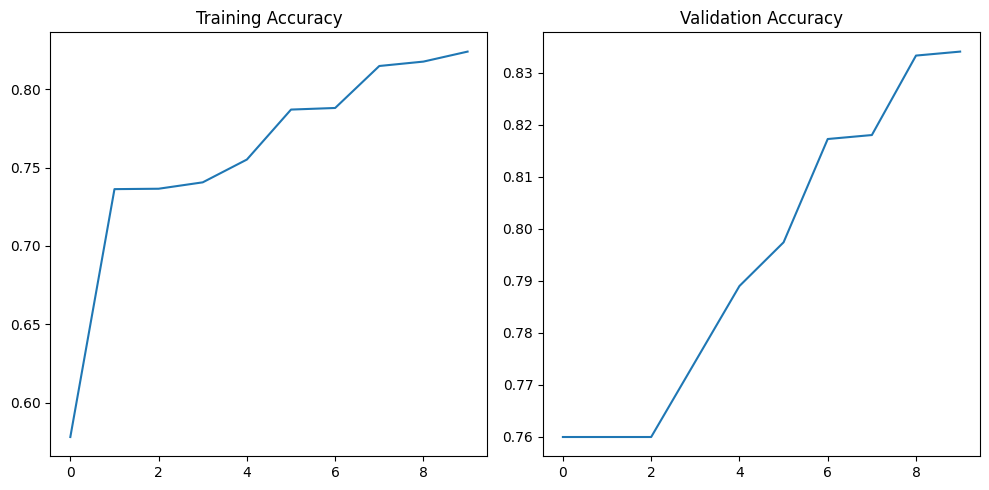

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(history.history['accuracy'])
axes[0].set_title('Training Accuracy')

axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

* For `10 epochs`, both training and validation accuracies gradually increase. More epochs could reveal the converging accuracies.

## <a id='evaluate'>Model Evaluation</a>

### CNN Model

In [43]:
cnn_model.evaluate(test_set_normalized)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - accuracy: 0.8558 - loss: 0.3330


[0.33731603622436523, 0.8541666865348816]

In [42]:
model_resnet101.evaluate(test_set_normalized)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6815 - loss: 0.5955


[0.6056486368179321, 0.6666666865348816]

* Both models show signs of overfitting. Regularisation methods should be implemented.